# Drug Consumption

## Data Understanding
### Import von benötigten Bibliotheken

In [234]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import numpy as np

### Datensatz abrufen

In [235]:
dataset = fetch_ucirepo(id=373)

### Daten (Features und Zielvariable)

### Erste Übersicht der Features und der Zielvariablen

In [236]:

X = dataset.data.features
y = dataset.data.targets
print(X.head())
X = dataset.data.features.drop(columns=['age', 'gender', 'ethnicity'], errors='ignore')

print("Übersicht der Merkmale:")
print(X.head())

print("")
print("Übersicht der Targets in den Zielklassen:")
print(y.head())

print("")
print("Übersicht über Datentypen im Datensatz")
print(X.dtypes)
print(y.dtypes)

       age   gender  education  country  ethnicity   nscore   escore   oscore  \
0  0.49788  0.48246   -0.05921  0.96082    0.12600  0.31287 -0.57545 -0.58331   
1 -0.07854 -0.48246    1.98437  0.96082   -0.31685 -0.67825  1.93886  1.43533   
2  0.49788 -0.48246   -0.05921  0.96082   -0.31685 -0.46725  0.80523 -0.84732   
3 -0.95197  0.48246    1.16365  0.96082   -0.31685 -0.14882 -0.80615 -0.01928   
4  0.49788  0.48246    1.98437  0.96082   -0.31685  0.73545 -1.63340 -0.45174   

    ascore   cscore  impuslive       ss  
0 -0.91699 -0.00665   -0.21712 -1.18084  
1  0.76096 -0.14277   -0.71126 -0.21575  
2 -1.62090 -1.01450   -1.37983  0.40148  
3  0.59042  0.58489   -1.37983 -1.18084  
4 -0.30172  1.30612   -0.21712 -0.21575  
Übersicht der Merkmale:
   education  country   nscore   escore   oscore   ascore   cscore  impuslive  \
0   -0.05921  0.96082  0.31287 -0.57545 -0.58331 -0.91699 -0.00665   -0.21712   
1    1.98437  0.96082 -0.67825  1.93886  1.43533  0.76096 -0.14277   -0.711

### Lage- und Streuungsmaße

Lage- und Streuungsmaße der Features:
         education      country       nscore       escore       oscore  \
count  1885.000000  1885.000000  1885.000000  1885.000000  1885.000000   
mean     -0.003806     0.355542     0.000047    -0.000163    -0.000534   
std       0.950078     0.700335     0.998106     0.997448     0.996229   
min      -2.435910    -0.570090    -3.464360    -3.273930    -3.273930   
25%      -0.611130    -0.570090    -0.678250    -0.695090    -0.717270   
50%      -0.059210     0.960820     0.042570     0.003320    -0.019280   
75%       0.454680     0.960820     0.629670     0.637790     0.723300   
max       1.984370     0.960820     3.273930     3.273930     2.901610   

            ascore       cscore    impuslive           ss  
count  1885.000000  1885.000000  1885.000000  1885.000000  
mean     -0.000245    -0.000386     0.007216    -0.003292  
std       0.997440     0.997523     0.954435     0.963701  
min      -3.464360    -3.464360    -2.555240    -2.0784

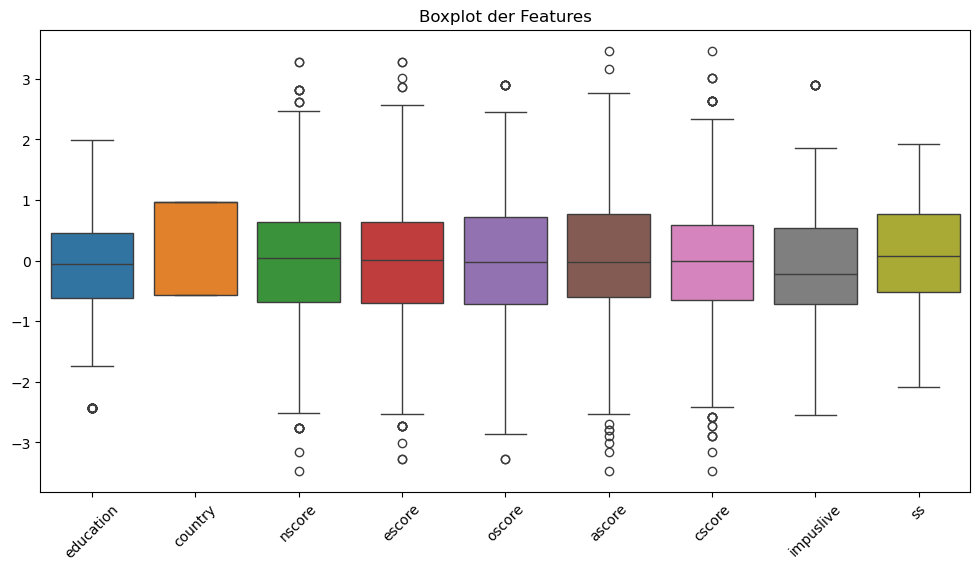

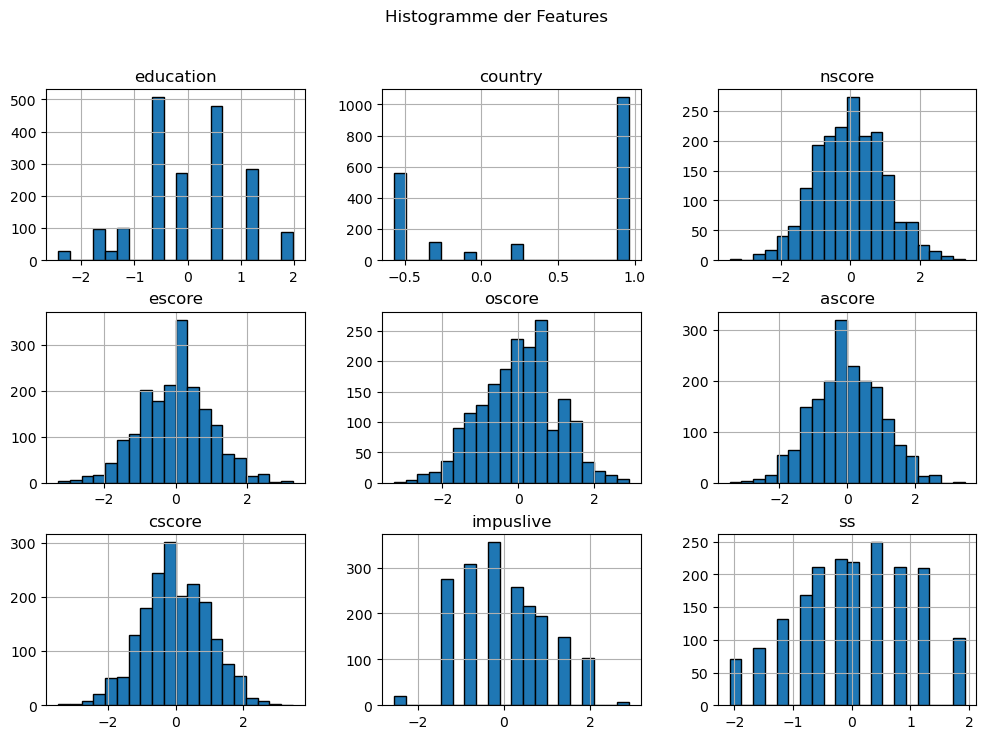

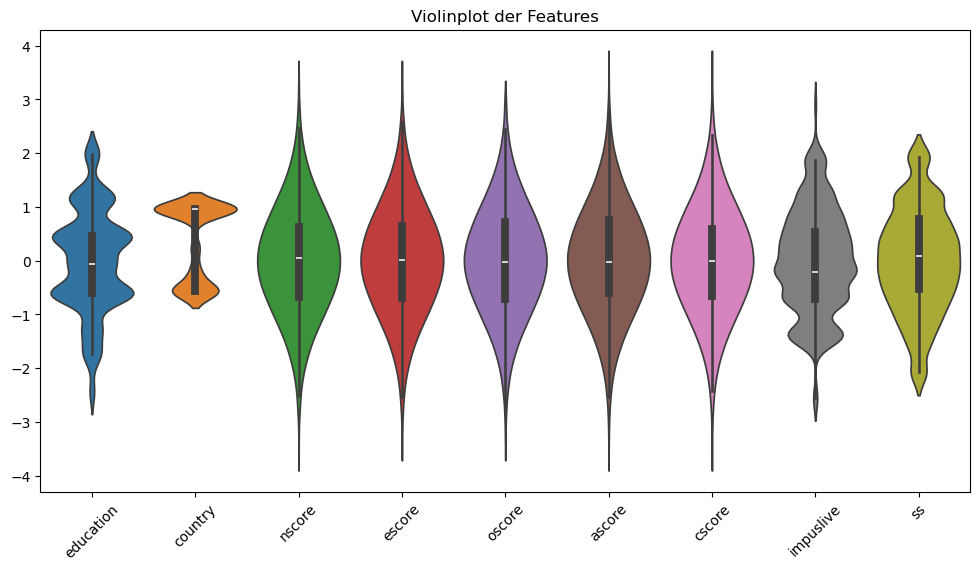

In [237]:
print("Lage- und Streuungsmaße der Features:")
print(X.describe())

plt.figure(figsize=(12, 6))
sns.boxplot(data=X)
plt.xticks(rotation=45)
plt.title("Boxplot der Features")
plt.show()

X.hist(figsize=(12, 8), bins=20, edgecolor="black")
plt.suptitle("Histogramme der Features")
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(data=X)
plt.xticks(rotation=45)
plt.title("Violinplot der Features")
plt.show()


### Enthaltene Drogen im Datensatz

In [238]:
drug_columns = ['cannabis', 'coke', 'ecstasy', 'heroin', 'meth', 'mushrooms', 'nicotine', 'lsd', 'amphet', 'crack', 'alcohol']

### Primäre Auswahl an zu analysierenden Drogen

In [239]:
chosen_drugs = ['cannabis', 'coke', 'nicotine'] 

### Visualisierung der Verteilung des Konsums für jede Droge

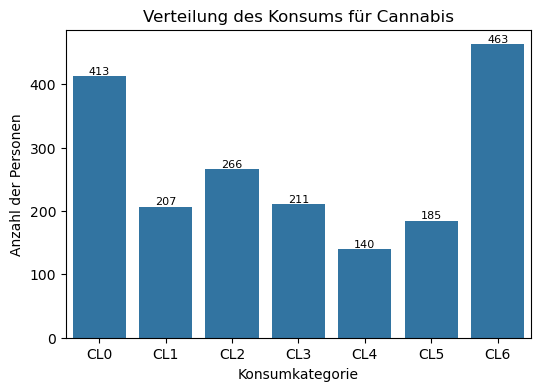

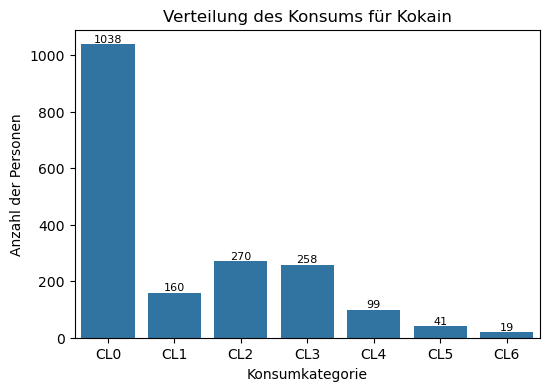

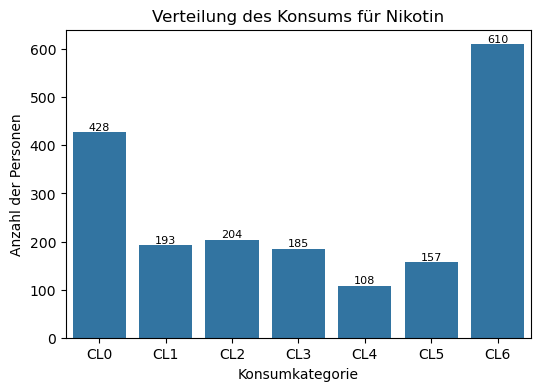

In [240]:
drug_names = {
    'cannabis': 'Cannabis',
    'coke': 'Kokain',
    'nicotine': 'Nikotin',
}

for drug in chosen_drugs:
    plt.figure(figsize=(6, 4))
    
    value_counts = y[drug].value_counts().sort_values(ascending=False)
    
    ordered_categories = ['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6']
    
    ax = sns.countplot(x=y[drug], order=ordered_categories)
    
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height,  
                f'{int(height)}', ha="center", va="bottom", fontsize=8)
    
    plt.title(f"Verteilung des Konsums für {drug_names.get(drug, drug).capitalize()}")
    plt.xlabel('Konsumkategorie')
    plt.ylabel('Anzahl der Personen')
    plt.show()


### Funktion, die Modelle erstellt und evaluiert

--> Zielvariable für die gewählte Droge

In [241]:
drug_names = ['cannabis', 'coke', 'nicotine']
y_selected = y[drug_names]

### Train-Test-Split

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y_selected, test_size=0.2, random_state=42)

### Verifizieren des Splits

In [243]:
print("\nTrainingsdaten (Features) : ", X_train.shape)
print("Testdaten (Features) : ", X_test.shape)


Trainingsdaten (Features) :  (1508, 9)
Testdaten (Features) :  (377, 9)


## Decision Tree Modell


In [244]:
dt_models = {}
y_pred_dt = {}

for drug in drug_names:
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train[drug]), y=y_train[drug])
    class_weight_dict = dict(zip(np.unique(y_train[drug]), class_weights))
    
    dt_model = DecisionTreeClassifier(
        random_state=42,
        class_weight=class_weight_dict,
        criterion='entropy',
        max_depth=10 if drug in ['coke', 'nicotine'] else 5,
        max_features='sqrt' if drug == 'nicotine' else None,
        min_samples_leaf=1,
        min_samples_split=2
    )
    
    dt_model.fit(X_train, y_train[drug])
    dt_models[drug] = dt_model
    y_pred_dt[drug] = dt_model.predict(X_test)


## Random Forest Modell

In [245]:
rf_models = {}
y_pred_rf = {}

for drug in drug_names:
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train[drug]), y=y_train[drug])
    class_weight_dict = dict(zip(np.unique(y_train[drug]), class_weights))
    
    rf_model = RandomForestClassifier(random_state=42, 
                                  class_weight=class_weight_dict, 
                                  n_estimators=100,
                                  max_depth=10,
                                  max_features='sqrt')
    rf_model.fit(X_train, y_train[drug])
    
    y_pred_rf[drug] = rf_model.predict(X_test)
    rf_models[drug] = rf_model

### Logistische Regression Modell


In [246]:
logreg_models = {}
y_pred_logreg = {}

for drug in drug_names:
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train[drug]), y=y_train[drug])
    class_weight_dict = dict(zip(np.unique(y_train[drug]), class_weights))
    
    logreg_model = LogisticRegression(max_iter=50, class_weight=class_weight_dict, random_state=42)
    logreg_model.fit(X_train, y_train[drug])
    
    y_pred_logreg[drug] = logreg_model.predict(X_test)
    logreg_models[drug] = logreg_model

### KNN

In [247]:
knn_models = {}
y_pred_knn = {}

for drug in drug_names:
    knn_model = KNeighborsClassifier(
        algorithm='auto',
        leaf_size=20,
        n_neighbors=11,
        p=1,
        weights='distance'
    )
    
    knn_model.fit(X_train, y_train[drug])
    
    y_pred_knn[drug] = knn_model.predict(X_test)
    knn_models[drug] = knn_model


### SVM Modell

In [248]:
svm_models = {}
y_pred_svm = {}

for drug in drug_names:    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train[drug]), y=y_train[drug])
    class_weight_dict = dict(zip(np.unique(y_train[drug]), class_weights))
    
    svm_model = SVC(kernel='linear', class_weight=class_weight_dict, random_state=42)
    svm_model.fit(X_train, y_train[drug])
    
    y_pred_svm[drug] = svm_model.predict(X_test)
    svm_models[drug] = svm_model

### Ergebnisse für alle Modelle

In [249]:
all_accuracies = {}
all_f1_scores = {}
all_classification_reports = {}
all_train_errors = {}
all_test_errors = {}

for drug in drug_names:
    print(f"\nErgebnisse für {drug}:")

    models = {
        "Random Forest": rf_models[drug],
        "Logistische Regression": logreg_models[drug],
        "SVM": svm_models[drug],
        "Decision Tree": dt_models[drug],
        "KNN": knn_models[drug]
    }

    accuracies, f1_scores_dict, classification_reports, train_errors, test_errors = {}, {}, {}, {}, {}

    for model_name, model in models.items():
        predictions = model.predict(X_test)
        accuracies[model_name] = accuracy_score(y_test[drug], predictions)
        f1_scores_dict[model_name] = f1_score(y_test[drug], predictions, average='macro')
        classification_reports[model_name] = classification_report(y_test[drug], predictions, zero_division=0)

        train_predictions = model.predict(X_train)
        train_errors[model_name] = 1 - accuracy_score(y_train[drug], train_predictions)
        test_errors[model_name] = 1 - accuracies[model_name]

    all_accuracies[drug] = accuracies
    all_f1_scores[drug] = f1_scores_dict
    all_classification_reports[drug] = classification_reports
    all_train_errors[drug] = train_errors
    all_test_errors[drug] = test_errors

    print("\nKlassifikationsberichte:")
    for model_name, report in classification_reports.items():
        print(f"\n{model_name}:")
        print(report)


Ergebnisse für cannabis:

Klassifikationsberichte:

Random Forest:
              precision    recall  f1-score   support

         CL0       0.50      0.65      0.56        86
         CL1       0.31      0.39      0.35        28
         CL2       0.10      0.07      0.09        55
         CL3       0.20      0.07      0.10        57
         CL4       0.00      0.00      0.00        27
         CL5       0.21      0.09      0.13        32
         CL6       0.45      0.72      0.55        92

    accuracy                           0.38       377
   macro avg       0.25      0.29      0.26       377
weighted avg       0.31      0.38      0.33       377


Logistische Regression:
              precision    recall  f1-score   support

         CL0       0.53      0.56      0.55        86
         CL1       0.13      0.29      0.18        28
         CL2       0.12      0.09      0.11        55
         CL3       0.25      0.18      0.21        57
         CL4       0.12      0.19      

### Ausgabe der Genauigkeit und Klassifikationsberichte

<Figure size 800x500 with 0 Axes>

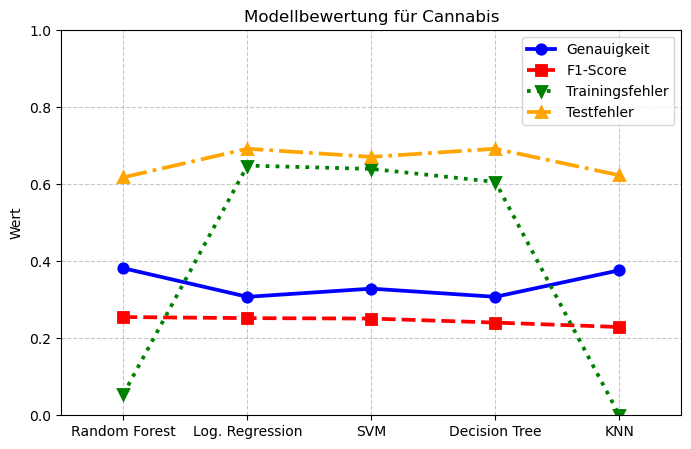

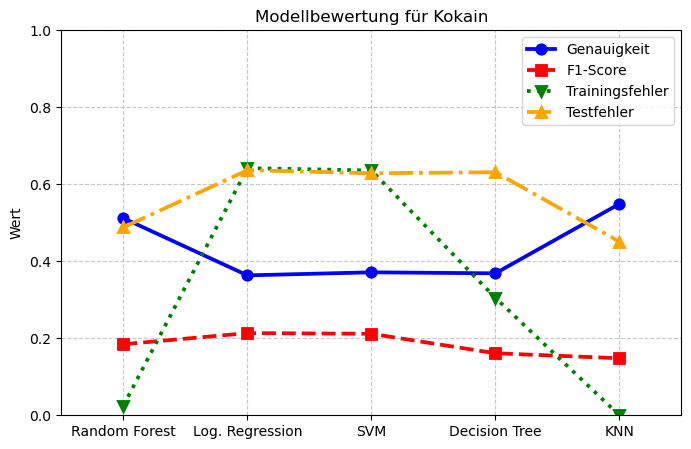

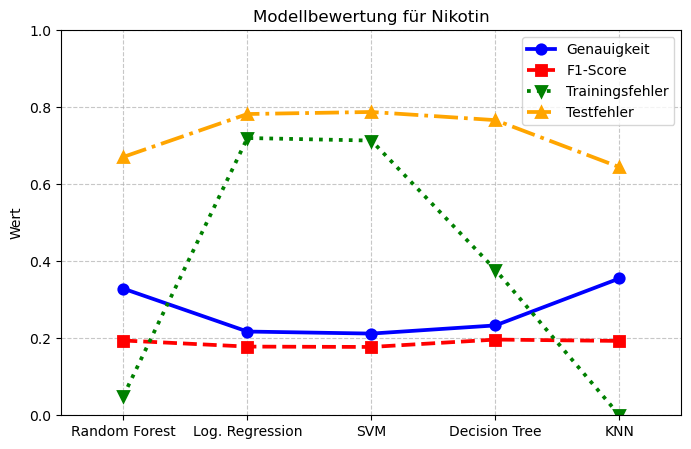

In [255]:
models = ["Random Forest", "Log. Regression", "SVM", "Decision Tree", "KNN"]

plt.figure(figsize=(8, 5))

for drug in drug_names:
    # Anpassung der Titel je nach Droge
    if drug == "cannabis":
        drug_title = "Modellbewertung für Cannabis"
    elif drug == "coke":
        drug_title = "Modellbewertung für Kokain"
    elif drug == "nicotine":
        drug_title = "Modellbewertung für Nikotin"
    else:
        drug_title = f"Modellbewertung für {drug}"

    accuracies = [
        all_accuracies[drug]["Random Forest"],
        all_accuracies[drug]["Logistische Regression"],
        all_accuracies[drug]["SVM"],
        all_accuracies[drug]["Decision Tree"],
        all_accuracies[drug]["KNN"]
    ]
    
    f1_scores = [
        all_f1_scores[drug]["Random Forest"],
        all_f1_scores[drug]["Logistische Regression"],
        all_f1_scores[drug]["SVM"],
        all_f1_scores[drug]["Decision Tree"],
        all_f1_scores[drug]["KNN"]
    ]

    train_errors = [
        all_train_errors[drug]["Random Forest"],
        all_train_errors[drug]["Logistische Regression"],
        all_train_errors[drug]["SVM"],
        all_train_errors[drug]["Decision Tree"],
        all_train_errors[drug]["KNN"]
    ]

    test_errors = [
        all_test_errors[drug]["Random Forest"],
        all_test_errors[drug]["Logistische Regression"],
        all_test_errors[drug]["SVM"],
        all_test_errors[drug]["Decision Tree"],
        all_test_errors[drug]["KNN"]
    ]
    
    # Plot der Genauigkeiten, F1-Scores und Fehler
    plt.figure(figsize=(8, 5))
    sns.pointplot(x=models, y=accuracies, color="blue", marker="o", linestyle="-", label="Genauigkeit")
    sns.pointplot(x=models, y=f1_scores, color="red", marker="s", linestyle="--", label="F1-Score")
    sns.pointplot(x=models, y=train_errors, color="green", marker="v", linestyle=":", label="Trainingsfehler")
    sns.pointplot(x=models, y=test_errors, color="orange", marker="^", linestyle="-.", label="Testfehler")

    plt.ylabel("Wert")
    plt.ylim(0, 1)
    plt.title(drug_title)  # Titel basierend auf der Droge setzen
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()


### Vergleich der Genauigkeiten

### Merkmalsgewichtung für trainierte Modelle

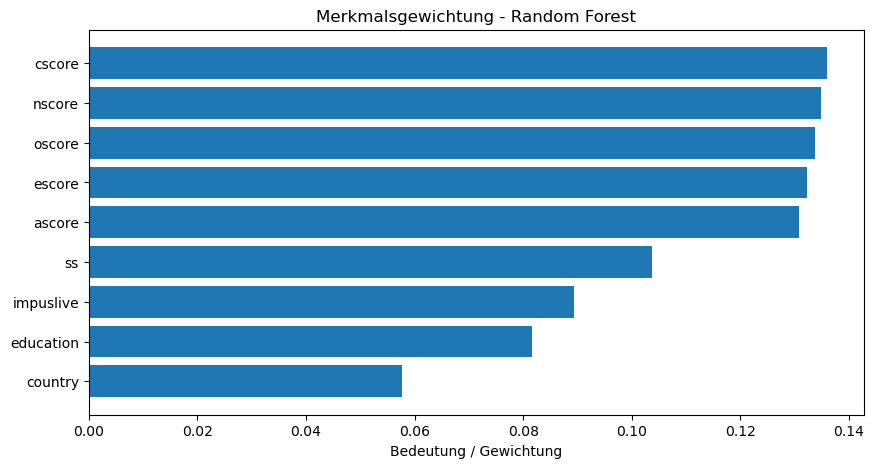

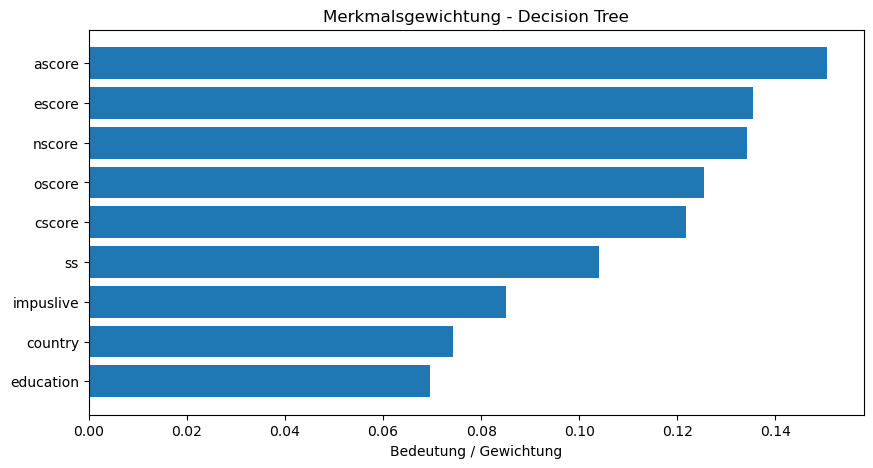

In [251]:
import numpy as np
import matplotlib.pyplot as plt

# Feature-Namen
num_features = X_train.shape[1]
feature_names = X_train.columns.tolist() if hasattr(X_train, "columns") else [f"Merkmal {i}" for i in range(num_features)]

def zeige_feature_importance(modellname, gewichtungen):
    if len(gewichtungen) != len(feature_names):
        return
    
    sortierte_indices = np.argsort(gewichtungen)
    plt.figure(figsize=(10, 5))
    plt.title(f"Merkmalsgewichtung - {modellname}")
    plt.barh(range(len(gewichtungen)), gewichtungen[sortierte_indices], align="center")
    plt.yticks(range(len(gewichtungen)), np.array(feature_names)[sortierte_indices])
    plt.xlabel("Bedeutung / Gewichtung")
    plt.show()

# Random Forest
if hasattr(rf_model, "feature_importances_"):
    zeige_feature_importance("Random Forest", rf_model.feature_importances_)

# Decision Tree
if hasattr(dt_model, "feature_importances_"):
    zeige_feature_importance("Decision Tree", dt_model.feature_importances_)


### Konfusionsmatrix für jedes Modell

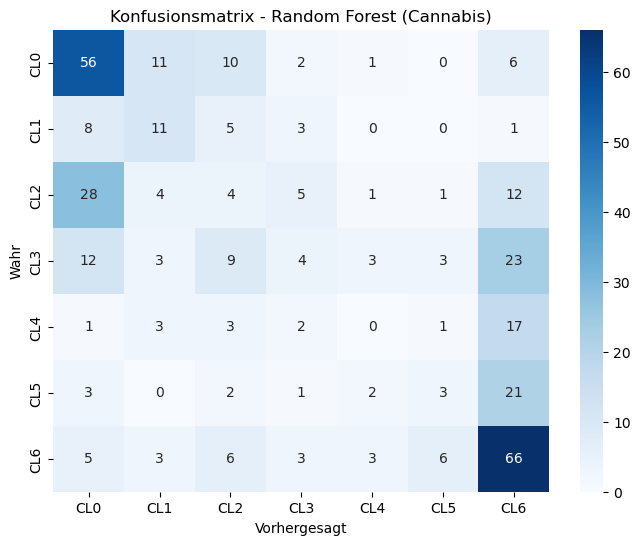

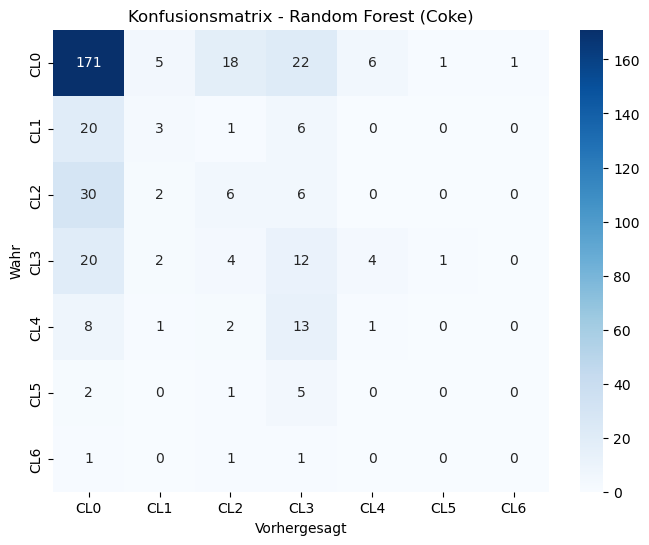

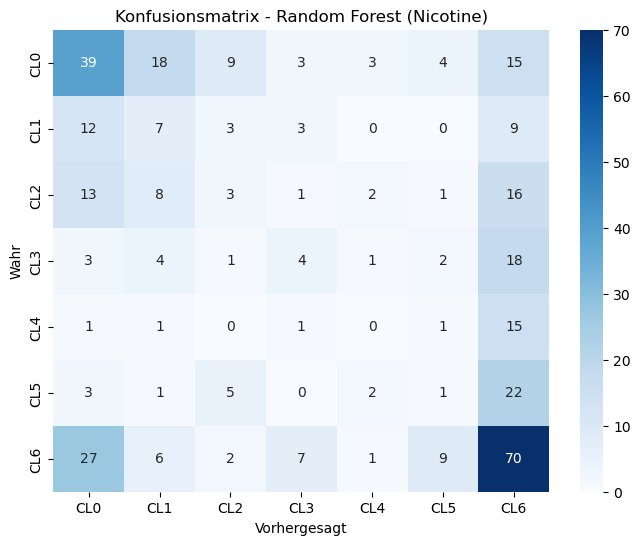

In [252]:
for drug in drug_names:
    conf_matrix = confusion_matrix(y_test[drug], y_pred_rf[drug])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'], yticklabels=['CL0', 'CL1', 'CL2', 'CL3', 'CL4', 'CL5', 'CL6'])
    
    plt.title(f"Konfusionsmatrix - Random Forest ({drug.capitalize()})")
    plt.xlabel("Vorhergesagt")
    plt.ylabel("Wahr")
    plt.show()

## Data Preparation

### Überprüfen auf Duplikate

In [253]:
print("Anzahl Duplikate im Datensatz: ", sum(X.duplicated()))

if sum(X.duplicated()) == 0: 
    print("Keine Duplikate im Datensatz.")

Anzahl Duplikate im Datensatz:  0
Keine Duplikate im Datensatz.


### Übersicht zu fehlenden Werten

In [254]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   education  1885 non-null   float64
 1   country    1885 non-null   float64
 2   nscore     1885 non-null   float64
 3   escore     1885 non-null   float64
 4   oscore     1885 non-null   float64
 5   ascore     1885 non-null   float64
 6   cscore     1885 non-null   float64
 7   impuslive  1885 non-null   float64
 8   ss         1885 non-null   float64
dtypes: float64(9)
memory usage: 132.7 KB
None
